In [1]:
import pandas as pd
import numpy as np

## Binarize

In [2]:
df_train = pd.read_csv('../dataset/TrainingDataset.csv')
df_test = pd.read_csv('../dataset/TestDataset.csv')

# 1 & 2 -> 1
# 0 -> 0

binarized = df_train['3-class'].values.copy()
binarized[binarized == 2] = 1
df_train['2-class-merged-v1'] = binarized.astype(int)

binarized = df_test['3-class'].values.copy()
binarized[binarized == 2] = 1
df_test['2-class-merged-v1'] = binarized.astype(int)


y_train = df_train['2-class-merged-v1'].values
y_test = df_test['2-class-merged-v1'].values

## Use All Features

In [3]:
np.unique(df_train['residue'])

array(['C', 'D', 'E', 'F', 'G', 'H', 'I', 'K', 'L', 'M', 'N', 'P', 'Q',
       'R', 'S', 'T', 'V', 'W', 'Y'], dtype=object)

In [4]:
# convert aa char to int
codes = ['A', 'R', 'N', 'D', 'C', 'E', 'Q', 'G', 'H', 
         'I', 'L', 'K', 'M', 'F', 'P', 'S', 'T', 'W', 'Y', 'V']
code_to_int = {c:i for i,c in enumerate(codes)}     
df_train['residue'] = df_train['residue'].map(code_to_int)
df_test['residue'] = df_test['residue'].map(code_to_int)

In [5]:
np.unique(df_train['secondary structure'])

array(['-', 'H', 'S', 'T'], dtype=object)

In [6]:
# convert secondary structure char to int
codes = ['H', 'S', 'T', '-']
code_to_int = {c:i for i,c in enumerate(codes)}     
df_train['secondary structure'] = df_train['secondary structure'].map(code_to_int)
df_test['secondary structure'] = df_test['secondary structure'].map(code_to_int)

feature_list = ['avg bond number', 'Hbond', 'residue',
                'Hphob', 'consurf', "B' side chain", 'secondary structure', 'asa']

df_train = df_train[feature_list]
df_test = df_test[feature_list]

In [7]:
df_train['residue'] = df_train['residue'].astype('category')
df_test['residue'] = df_test['residue'].astype('category')

df_train['secondary structure'] = df_train['secondary structure'].astype('category')
df_test['secondary structure'] = df_test['secondary structure'].astype('category')

In [8]:
df_train.dtypes

avg bond number         float64
Hbond                     int64
residue                category
Hphob                     int64
consurf                   int64
B' side chain           float64
secondary structure    category
asa                     float64
dtype: object

In [9]:
X_train = df_train[feature_list].values
X_test =  df_test[feature_list].values

In [10]:
X_train.shape

(732, 8)

In [11]:
y_train.shape

(732,)

In [12]:
X_test.shape

(314, 8)

In [13]:
y_test.shape

(314,)

In [14]:
X_train[:, [2, 6]]

array([[13.,  3.],
       [ 1.,  1.],
       [14.,  3.],
       ...,
       [19.,  2.],
       [14.,  2.],
       [ 1.,  3.]])

## OneHot Encoding

In [15]:
from sklearn.preprocessing import OneHotEncoder

ohe = OneHotEncoder(drop='first')
ohe.fit(df_train[feature_list][['residue', 'secondary structure']])

OneHotEncoder(drop='first')

In [16]:
df_train_ohe = df_train.drop(columns=['residue', 'secondary structure'])
df_test_ohe = df_test.drop(columns=['residue', 'secondary structure'])

In [17]:
ohe_train = np.asarray(ohe.transform(df_train[feature_list][['residue', 'secondary structure']]).todense())
ohe_test = np.asarray(ohe.transform(df_test[feature_list][['residue', 'secondary structure']]).todense())

In [18]:
X_train_ohe = np.hstack((df_train_ohe.values, ohe_train))
X_test_ohe = np.hstack((df_test_ohe.values, ohe_test))

## HistGradientBoostingClassifier

In [19]:
import numpy as np
import scipy.stats

from sklearn.experimental import enable_halving_search_cv
from sklearn.model_selection import HalvingRandomSearchCV
from sklearn.model_selection import RandomizedSearchCV
from sklearn.ensemble import HistGradientBoostingClassifier


model = HistGradientBoostingClassifier(
    categorical_features=[2, 6],
    loss='log_loss')

params = {
    'learning_rate': scipy.stats.loguniform(1e-10, 1e2),
    'max_leaf_nodes': scipy.stats.uniform(1, 1000),
    'min_samples_leaf': scipy.stats.uniform(1, 1000),
    'max_iter': (100, 200, 300),
    'l2_regularization': scipy.stats.loguniform(1e-10, 1e10)

}


"""
search = HalvingRandomSearchCV(
    estimator=model, 
    param_distributions=params,
    n_candidates='exhaust',
    resource='n_samples',
    factor=3,
    scoring='f1',
    cv=10,
    random_state=123,
    n_jobs=-1)
"""

search = RandomizedSearchCV(
    estimator=model,
    param_distributions=params,
    n_iter=50000,
    cv=10,
    scoring='f1',
    verbose=1,
    n_jobs=-1)

search.fit(X_train, y_train)

print(search.best_params_)
print(search.best_score_)

Fitting 10 folds for each of 50000 candidates, totalling 500000 fits
{'l2_regularization': 4.0461426652564415e-10, 'learning_rate': 6.7703956715088776, 'max_iter': 200, 'max_leaf_nodes': 552.1708798358676, 'min_samples_leaf': 111.7483353734513}
0.627169958040909


In [20]:
from sklearn.model_selection import cross_val_score


score_names = ['precision', 'recall', 'f1']

for score_name in score_names:

    scores = cross_val_score(
        X=X_train,
        y=y_train,
        estimator=search.best_estimator_,
        cv=10,
        n_jobs=-1,
        scoring=score_name
    )
    
    print(f'{score_name}: {np.mean(scores):.2f} +/- {np.std(scores):.2f}')

precision: 0.61 +/- 0.06
recall: 0.66 +/- 0.09
f1: 0.63 +/- 0.06


In [21]:
from sklearn.metrics import f1_score, precision_score, recall_score

pred = search.best_estimator_.predict(X_test)

print(f'Test precision: {precision_score(pred, y_test):.2f}')
print(f'Test recall: {recall_score(pred, y_test):.2f}')
print(f'Test F1: {f1_score(pred, y_test):.2f}')

Test precision: 0.57
Test recall: 0.50
Test F1: 0.53


In [22]:
X_data = np.vstack((X_train, X_test))
y_data = np.hstack((y_train, y_test))

In [23]:
from sklearn.model_selection import train_test_split

rng = np.random.RandomState(seed=123)
seeds = np.arange(10**5)
rng.shuffle(seeds)
seeds = seeds[:500]

all_pre, all_rec, all_f1 = [], [], []

for i in seeds:
    X_train, X_test, y_train, y_test = train_test_split(X_data, y_data,
                                                        test_size=0.3, 
                                                        random_state=i,
                                                        stratify=y_data)
    y_pred_i = search.best_estimator_.fit(X_train, y_train).predict(X_test)
    
    y_pre_i = precision_score(y_pred_i, y_test)
    y_rec_i = recall_score(y_pred_i, y_test)
    y_f1_i = f1_score(y_pred_i, y_test)
    
    all_pre.append(y_pre_i)
    all_rec.append(y_rec_i)
    all_f1.append(y_f1_i)

all_pre = np.asarray(all_pre)
all_rec = np.asarray(all_rec)
all_f1 = np.asarray(all_f1)

In [24]:
import matplotlib.pyplot as plt
%matplotlib inline

Average: 52.13%


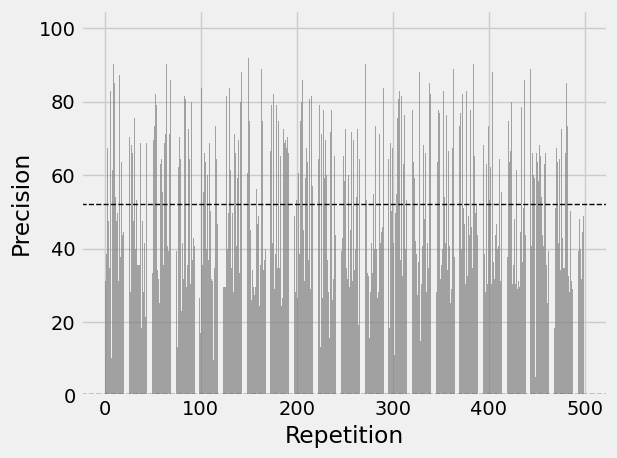

In [25]:
pred_2 = all_pre

print('Average: %.2f%%' % (pred_2.mean()*100))

with plt.style.context(('fivethirtyeight')):
    plt.bar(range(0, pred_2.shape[0]), pred_2*100, color='gray', alpha=0.7)
    ##plt.axhline(pred_2.max(), color='k', linewidth=1, linestyle='--')
    plt.axhline(pred_2.mean()*100, color='k', linewidth=1, linestyle='--')
    #plt.axhspan(pred_2.min(), pred_2.max(), alpha=0.2, color='steelblue')
    
    plt.axhline(pred_2.mean(), color='k', linewidth=1, linestyle='--')
    
    plt.ylim([0, pred_2.max()*100 + 10])
    plt.xlabel('Repetition')
    plt.ylabel('Precision')
    plt.ylim([0, 105])
    plt.tight_layout()
    #plt.savefig('plots/01.1_repeated_precision.pdf')
    plt.show()

Average: 41.98%


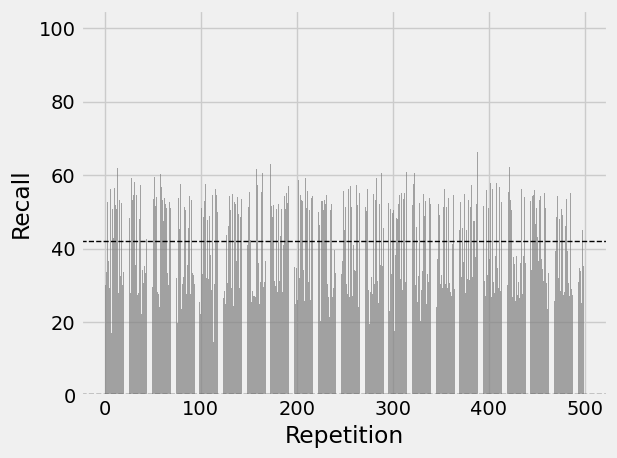

In [26]:
pred_2 = all_rec

print('Average: %.2f%%' % (pred_2.mean()*100))

with plt.style.context(('fivethirtyeight')):
    plt.bar(range(0, pred_2.shape[0]), pred_2*100, color='gray', alpha=0.7)
    ##plt.axhline(pred_2.max(), color='k', linewidth=1, linestyle='--')
    plt.axhline(pred_2.mean()*100, color='k', linewidth=1, linestyle='--')
    #plt.axhspan(pred_2.min(), pred_2.max(), alpha=0.2, color='steelblue')
    
    plt.axhline(pred_2.mean(), color='k', linewidth=1, linestyle='--')
    
    plt.ylim([0, pred_2.max()*100 + 10])
    plt.xlabel('Repetition')
    plt.ylabel('Recall')
    plt.ylim([0, 105])
    plt.tight_layout()
    #plt.savefig('plots/01.1_repeated_recall.pdf')
    plt.show()

Average: 45.90%


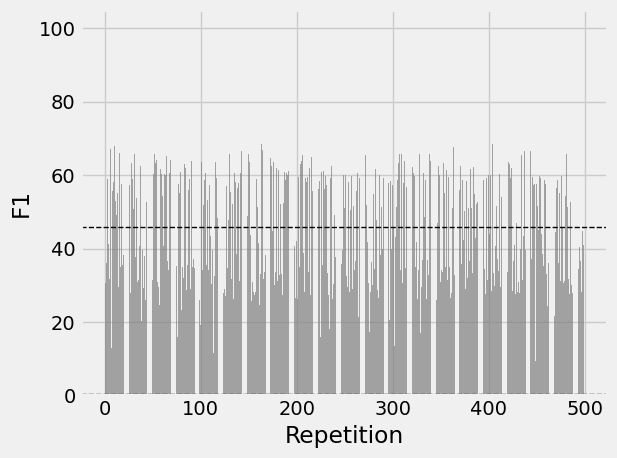

In [27]:
pred_2 = all_f1

print('Average: %.2f%%' % (pred_2.mean()*100))

with plt.style.context(('fivethirtyeight')):
    plt.bar(range(0, pred_2.shape[0]), pred_2*100, color='gray', alpha=0.7)
    ##plt.axhline(pred_2.max(), color='k', linewidth=1, linestyle='--')
    plt.axhline(pred_2.mean()*100, color='k', linewidth=1, linestyle='--')
    #plt.axhspan(pred_2.min(), pred_2.max(), alpha=0.2, color='steelblue')
    
    plt.axhline(pred_2.mean(), color='k', linewidth=1, linestyle='--')
    
    plt.ylim([0, pred_2.max()*100 + 10])
    plt.xlabel('Repetition')
    plt.ylabel('F1')
    plt.ylim([0, 105])
    plt.tight_layout()
    plt.savefig('hgbm_large_repeated_f1.pdf')
    plt.show()